In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler

# df 경로는 각자 설정
df = pd.read_csv("../../data/통합데이터/Final_merged_all_data.csv")
# df = df.sort_values(by=['발급회원번호', '기준년월'])

# -------------------------------------------------------
# 1. 6개월 기울기(Slope) 계산 (df에 바로 생성)
# -------------------------------------------------------
def calc_slope_6m(series):
    if len(series) < 2 or np.sum(series) == 0: return 0
    y = series.values
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return slope

# transform으로 전체 데이터에 기울기 적용
df['Slope_Spend'] = df.groupby('발급회원번호')['이용금액_신용_B0M'].transform(calc_slope_6m)
df['Slope_Balance'] = df.groupby('발급회원번호')['잔액_B0M'].transform(calc_slope_6m)
df['Slope_Count'] = df.groupby('발급회원번호')['이용건수_신용_B0M'].transform(calc_slope_6m)

# -------------------------------------------------------
# 2. 현재 시점(12월) 데이터만 추출
# -------------------------------------------------------
target_month = df['기준년월'].max()
df_final = df[df['기준년월'] == target_month].copy()

# -------------------------------------------------------
# 3. [핵심] 기울기를 '이탈 점수'로 변환 (Normalization)
# -------------------------------------------------------
# 전략: 기울기가 음수일수록(가파른 감소) 높은 점수를 줍니다.
# 양수(증가)인 경우는 이탈 위험이 없으므로 0점으로 처리합니다.

scaler = MinMaxScaler()

def convert_slope_to_score(col_name):
    # 1. 감소하는 경우(음수)만 추출, 나머지는 0으로 대치
    # (음수 값에 -1을 곱해 양수로 만듦: -5000 -> 5000)
    # 즉, 값이 클수록 '많이 줄어듦'을 의미하게 됨
    negative_slopes = df_final[col_name].apply(lambda x: -x if x < 0 else 0)
    
    # 2. 0~1 사이 값으로 정규화 (MinMax Scaling)
    # 가장 많이 줄어든 사람이 1.0, 안 줄어든 사람이 0.0
    return scaler.fit_transform(negative_slopes.values.reshape(-1, 1)).flatten()

# 각 지표별 '감소 심각도' (0.0 ~ 1.0)
score_spend_norm = convert_slope_to_score('Slope_Spend')
score_balance_norm = convert_slope_to_score('Slope_Balance')
score_count_norm = convert_slope_to_score('Slope_Count')

# -------------------------------------------------------
# 4. 가중치 적용 및 최종 점수 산출 (100점 만점)
# -------------------------------------------------------
# 가중치 설정 (비즈니스 중요도에 따라 조절 가능)
W_SPEND = 40   # 소비 감소 비중
W_BALANCE = 30 # 잔액 감소(이탈준비) 비중
W_COUNT = 20   # 빈도 감소 비중
W_RISK = 10    # 현재 연체 등 리스크 비중

# (1) 리스크 점수 별도 계산 (0 or 10점)
# 연체나 승인거절이 하나라도 있으면 10점 만점 부여
has_risk = np.where(
    (df_final.get('연체잔액_B0M', 0) > 0) | 
    (df_final.get('승인거절건수_B0M', 0) > 0), 
    1, 0
)

# (2) 최종 스코어 계산
df_final['Churn_Score'] = (
    (score_spend_norm * W_SPEND) + 
    (score_balance_norm * W_BALANCE) + 
    (score_count_norm * W_COUNT) + 
    (has_risk * W_RISK)
)

# 소수점 정리
df_final['Churn_Score'] = df_final['Churn_Score'].round(1)

# 출력
print("\n[이탈 위험 점수(Churn Score) 상위 10명]")
cols_view = ['발급회원번호', 'Slope_Spend', 'Slope_Balance', 'Churn_Score']
print(df_final[cols_view].sort_values('Churn_Score', ascending=False).head(10))



[이탈 위험 점수(Churn Score) 상위 10명]
         발급회원번호    Slope_Spend  Slope_Balance  Churn_Score
56996  SYN_6996 -259949.057143 -466081.371429         65.5
52794  SYN_2794 -252282.000000 -115305.971429         59.9
53968  SYN_3968 -243906.428571 -117226.657143         51.1
59037  SYN_9037 -229686.857143 -119831.371429         47.7
55559  SYN_5559 -269313.542857  -44089.685714         45.9
53956  SYN_3956 -222279.228571 -168815.114286         42.1
55455  SYN_5455 -223850.714286  -61721.000000         41.3
55296  SYN_5296 -206826.314286 -381888.542857         41.0
53442  SYN_3442 -168908.285714 -186469.485714         39.1
51527  SYN_1527 -186951.657143 -241112.200000         38.0


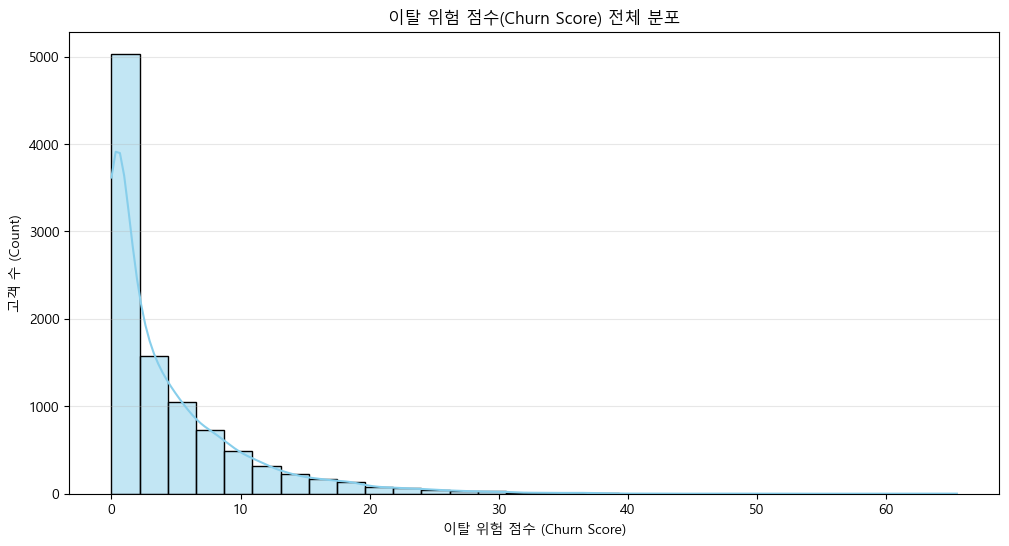

점수 평균: 4.33
점수 중앙값: 2.10


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 설정 (Windows)
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False

# 시각화: Churn Score 분포
plt.figure(figsize=(12, 6))
sns.histplot(data=df_final, x='Churn_Score', kde=True, bins=30, color='skyblue')
plt.title('이탈 위험 점수(Churn Score) 전체 분포')
plt.xlabel('이탈 위험 점수 (Churn Score)')
plt.ylabel('고객 수 (Count)')
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"점수 평균: {df_final['Churn_Score'].mean():.2f}")
print(f"점수 중앙값: {df_final['Churn_Score'].median():.2f}")

In [4]:
df_final['Churn_Score'].value_counts(normalize=True)

Churn_Score
0.0     0.1964
0.6     0.0273
0.2     0.0246
0.4     0.0214
1.1     0.0201
         ...  
29.3    0.0001
37.4    0.0001
30.5    0.0001
27.1    0.0001
19.6    0.0001
Name: proportion, Length: 330, dtype: float64